# Mini-projet n°1 - Chats ou Chiens ?

Dans ce projet, nous allons étudier, classifier et segmenter les images du jeu de données Oxford-IIIT Pet Dataset. Ce jeu de données comporte des images de chats et chiens de 37 races différentes.

In [6]:
# Utils
import os
#import shutil
import time
import tensorflow as tf


In [56]:
# Maths - Stats
import numpy as np
import pandas as pd
import random as rd
import scipy.stats as stats
from scipy.stats import shapiro
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [8]:
# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image 

In [9]:
# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

## Chargement des données

In [10]:
list = "./annotations//list.txt"
image_dir = "./images"

# Chargement des images du dataset
images = [f for f in os.listdir(image_dir) if f.lower().endswith("jpg")]
print("Il y a ", len(images), "images dans le dataset.")

# Chargement des informations (label) des images, avec le fichier list.txt
df = pd.read_csv(
    list,
    sep=r'\s+',          
    comment='#',         
    header=None,         
    usecols=[0, 1, 2], 
    names=['image', # nom de l'image (sans extension)
           'class_id', # identifiant de la classe (race), entre 1 et 37
           'type'] # type d'animal : 1=chat, 2=chien
)
df["image"] = df["image"].apply(lambda x: x + ".jpg")
n_total = len(df)
print(f"Il y a {n_total} images référencées dans list.txt.")

# Vérification du référencement des images
missing_list = sorted(set(images) - set(df["image"])) # images dans le dataset sans entrée dans list.txt
missing_images = sorted(set(df["image"]) - set(images)) # images référencées dans list.txt mais manquantes dans le dataset
print(f"Il y a {len(missing_list)} images dans le dataset sans entrée dans list.txt.")
print(f"Il y a {len(missing_images)} images référencées dans list.txt mais manquantes dans le dataset.")  

pd.set_option('display.max_rows', None)    # affiche toutes les lignes
pd.set_option('display.max_columns', None) # affiche toutes les colonnes
pd.set_option('display.width', None)       # pas de coupure de lignes
pd.set_option('display.max_colwidth', None) # montre le texte entier dans chaque cellule

Il y a  7390 images dans le dataset.
Il y a 7349 images référencées dans list.txt.
Il y a 41 images dans le dataset sans entrée dans list.txt.
Il y a 0 images référencées dans list.txt mais manquantes dans le dataset.


Certaines images existent dans le dossier "images", mais n'ont pas d'entrées dans list.txt. On va donc les faire rentrer dans le jeu de données, en mettant comme identifiant de classe et type la même chose que les autres fichiers commençant par le même nom.

In [11]:
def get_prefix(filename):
    return filename.split('_')[0]

# Ajout d'informations dans le DataFrame
df["class"] = df["image"].apply(get_prefix)
df["animal"] = df["type"].apply(lambda x: "cat" if x == 1 else "dog")

# Création d'un dictionnaire de classes connues
classes = (
    df.groupby("class")[["class_id", "type"]]
      .first()
      .to_dict(orient="index")
)

# Ajout du référencement des images dans le DataFrame
new_rows = []
for img in missing_list :
    class_name = get_prefix(img)
    if class_name in classes: # Si on ne connait pas, on ne rajoute pas au DataFrame
        class_id = classes[class_name]["class_id"]
        type = classes[class_name]["type"]
        new_rows.append({
            "image": os.path.splitext(img)[0],
            "class_id": class_id,
            "type": type,
            "class": class_name,
            "animal": "cat" if type == 1 else "dog"
        })

print(f"{len(new_rows)} nouvelles lignes créées.")
df_new = pd.DataFrame(new_rows)
df_full = pd.concat([df, df_new], ignore_index=True)
df_full["image"] = df_full["image"].apply(
    lambda x: x + ".jpg" if not x.lower().endswith(".jpg") else x
)

missing_images = sorted(set(images) - set(df_full["image"]))
print(f"Il y a maintenant {len(missing_images)} images du dataset qui ne sont pas référencées dans le DataFrame.")


df_full.head()

41 nouvelles lignes créées.
Il y a maintenant 0 images du dataset qui ne sont pas référencées dans le DataFrame.


image  class_id  type       class animal
0  Abyssinian_100.jpg         1     1  Abyssinian    cat
1  Abyssinian_101.jpg         1     1  Abyssinian    cat
2  Abyssinian_102.jpg         1     1  Abyssinian    cat
3  Abyssinian_103.jpg         1     1  Abyssinian    cat
4  Abyssinian_104.jpg         1     1  Abyssinian    cat

In [12]:
# Nettoyage 
del(df)
df = df_full
del(new_rows)
del(df_new)
del(df_full)

## Analyse exploratoire

### Etude de la répartition par race et par type

In [13]:
df["class"] = df["class"].astype("str")
df["animal"] = df["animal"].astype("str")
df.dtypes

image       object
class_id     int64
type         int64
class       object
animal      object
dtype: object

In [14]:
nb_images = len(df)
n_class = df["class"].nunique()
n_class_cat = df[df["animal"] == "cat"]["class"].nunique()
n_class_dog = df[df["animal"] == "dog"]["class"].nunique()
nb_cat = len(df[df["animal"] == "cat"])
nb_dog = len(df[df["animal"] == "dog"])

print(f"Il y a {n_class} races différentes dans le dataset, pour {nb_images} images.")
print(f"Il y a {n_class_cat} races de chats et {n_class_dog} races de chiens.")
print(f"Cela représente {nb_cat} images de chats et {nb_dog} images de chiens.")


Il y a 35 races différentes dans le dataset, pour 7390 images.
Il y a 12 races de chats et 23 races de chiens.
Cela représente 2400 images de chats et 4990 images de chiens.


/tmp/ipykernel_4297/158086272.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_2.values, y=counts_2.index, palette="pastel", ax=axes[0,1])


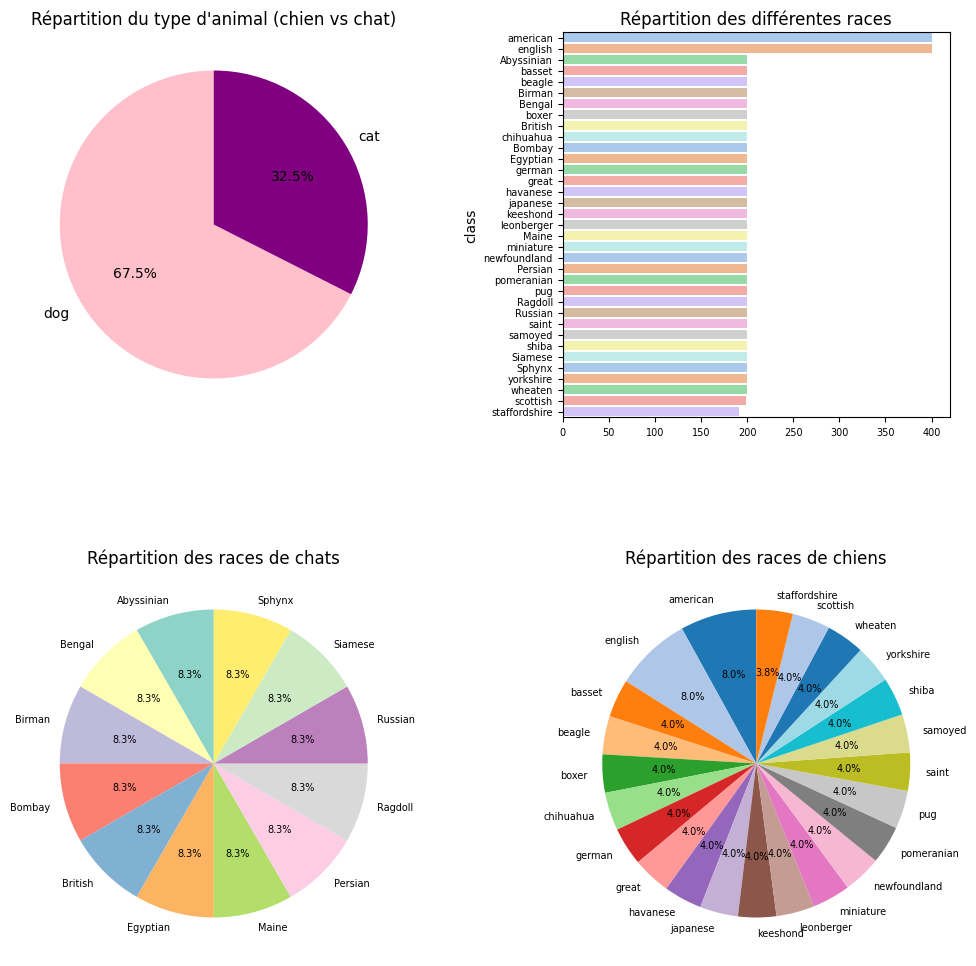

In [15]:
# Nombre d’images par type d'animal : chien vs chat
counts_1 = df["animal"].value_counts()

# Nombre d’images par race
counts_2 = df["class"].value_counts()

# Parmi les chats, répartition des races
counts_3 = df[df["animal"] == "cat"]["class"].value_counts()
counts_3 = counts_3[counts_3 > 0]
labels_cats =  [c for c in counts_3.index if counts_3[c] > 0]
palette_cat = sns.color_palette("Set3", n_colors=len(counts_3))

# Parmi les chiens, répartition des races
counts_4 = df[df["animal"] == "dog"]["class"].value_counts()
counts_4 = counts_4[counts_4 > 0]
labels_dogs =  [c for c in counts_4.index if counts_4[c] > 0]
palette_dog = sns.color_palette("tab20", n_colors=len(counts_4))

# Affichage des graphiques
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

axes[0,0].pie(counts_1, labels=counts_1.index, autopct='%1.1f%%', startangle=90, colors=["pink", "purple"])
axes[0,0].set_title("Répartition du type d'animal (chien vs chat)")

sns.barplot(x=counts_2.values, y=counts_2.index, palette="pastel", ax=axes[0,1])
axes[0,1].set_title("Répartition des différentes races")
axes[0,1].tick_params(axis='x', labelsize=7)
axes[0,1].tick_params(axis='y', labelsize=7) 

axes[1,0].pie(counts_3, labels=labels_cats, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7}, colors=palette_cat)
axes[1,0].set_title("Répartition des races de chats")

axes[1,1].pie(x=counts_4,  labels=counts_4.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7}, colors=palette_dog)
axes[1,1].set_title("Répartition des races de chiens")

plt.tight_layout
fig.subplots_adjust(hspace=0.4, wspace=0.4)  

plt.show()


Dans ce dataset, il y a beaucoup plus de chiens (67.5%) que de chats (32.5%). Malgré tout, les différentes races sont dans l'ensemble bien réparties puisqu'il y a 200 images pour chaque race, à l'exception des races "american" et "english", qui comportent 400 individus chacune. La race "staffordshire" comporte quant à elle un tout petit peu moins de 200 individus. Lorsque l'on regarde la répartion des 12 races de chats parmis les chats, elles sont parfaitement équilibrées. Pour la répartition des 27 races de chien, on avait effectivement remarqué que 2 étaient plus représentées les autres. Le reste est néanmoins équilibré. 

### Vérification de la cohérence et la qualité des masques de segmentation

Un masque de segmentation est un masque de la même taille que l'image, qui va nous permettre d'avoir l'information du sujet de l'image. En effet, le masque va donner à chaque pixel de l'image une valeur parmi ces trois : 
- 1 si le pixel appartient au premier plan de l'image, soit l'animal dans notre cas 
- 2 si le pixel appartient à l'arrière-plan de l'image 
- 3 si le pixel n'est pas classifié.

Les masques de segmentation se trouvent dans le dossier *annotations/trimaps*. Nous allons donc regarder sur un petit jeu de données, sélectionné aléatoirement parmi notre dataset ce que donne le masque de segmentation. 


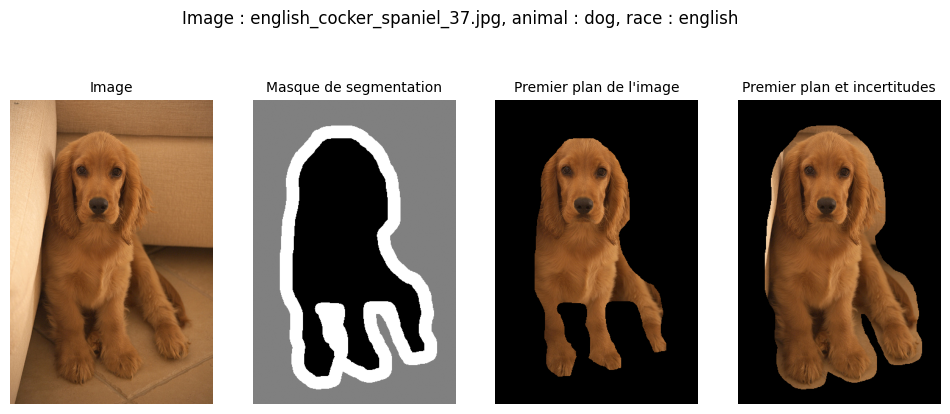

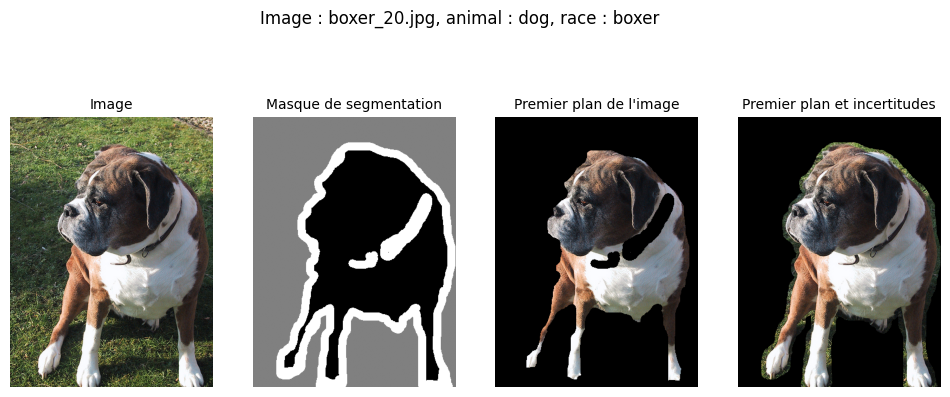

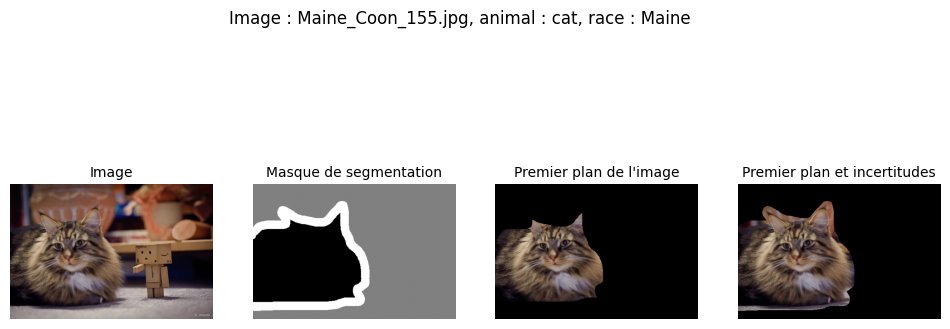

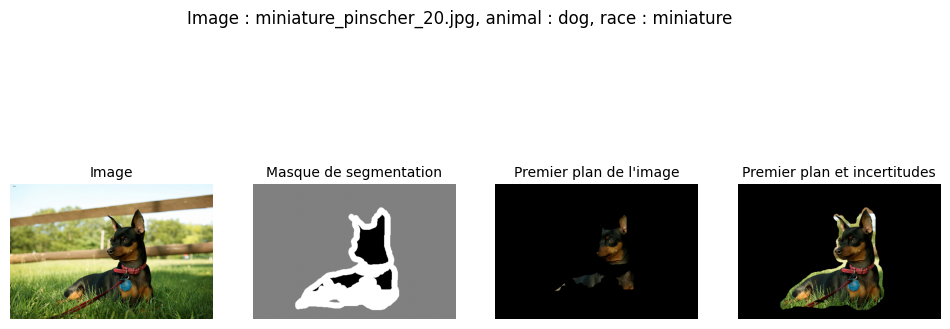

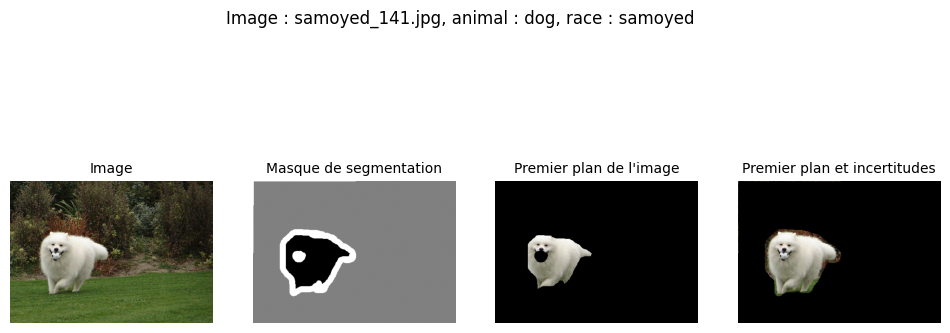

In [16]:
path_images = "./images/"
path_masks = "./annotations/trimaps/"

n = 5

for i in range(5): 
    # Sélection aléatoire d'une image
    filename = rd.choice(df['image'])

    # Chargement de l'image et du masque
    img = np.array(Image.open(path_images + filename))
    mask = np.array(Image.open(path_masks + filename.replace('.jpg', '.png')))

    # Image avec le masque appliqué (seulement le corps de l'animal)
    img_foreground = img.copy()
    img_foreground[mask != 1] = 0  

    # Image avec le masque appliqué (corps de l'animal + zone d'incertitude)
    img_background = img.copy()
    img_background[mask == 2] = 0

    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    fig.suptitle(f"Image : {filename}, animal : {df[df['image'] == filename]['animal'].values[0]}, race : {df[df['image'] == filename]['class'].values[0]}")

    axes[0].imshow(img)
    axes[0].set_title("Image", fontsize=10)
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Masque de segmentation", fontsize=10)
    axes[1].axis("off")

    axes[2].imshow(img_foreground)  
    axes[2].set_title("Premier plan de l'image", fontsize=10)
    axes[2].axis("off")

    axes[3].imshow(img_background)
    axes[3].set_title("Premier plan et incertitudes", fontsize=10)
    axes[3].axis("off")

    plt.show()

Cela nous permet de vérifier que les masques sont cohérents avec l'image. Cependant, pour certaines photos, la zone d'incertitude peut être assez grande. C'est notamment le cas lorsque l'animal est de la même couleur que l'arrière plan, qu'il est caché par un objet, qu'il a des moustaches ou un collier. 

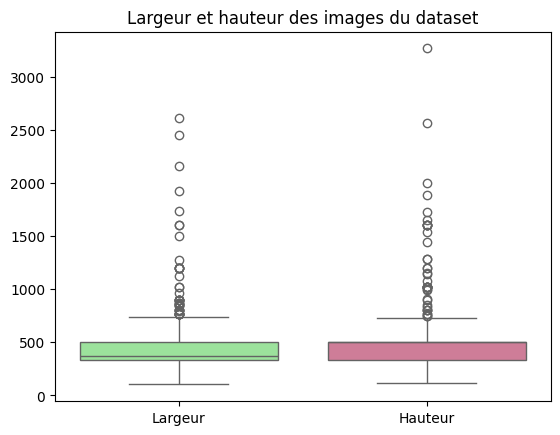

In [18]:
img_size = np.zeros((df.shape[0],2))
for i, filename in enumerate(df['image']) :
    img = img_to_array(load_img(path_images + filename) )
    img_size[i,:] = img.shape[:2]

plt.figure()
ax = sns.boxplot(img_size, palette = ['lightgreen', 'palevioletred'])
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['Largeur', 'Hauteur'])
plt.title("Largeur et hauteur des images du dataset")
plt.show()

On peut voir que les hauteurs et largeurs des images sont bien différentes. Pour la suite, on va les faire passer dans des réseaux de convolution. Il est donc intéressant d'avoir des images de même taille. 

## Classification binaire

Le premier objectif est de faire une classification binaire : à partir d'une photo, le but est de déterminer si elle montre un chat ou un chien.

### Pré - traitement des données

Dans un premier temps, nous séparons le jeu de données en un jeu de données pour l'entrainement, un pour la validation et un dernier qui sera utilisé pour tester le modèle à la fin.

In [19]:
N_train = 5200 # taille du jeu d'entrainement
N_validation = 1400 # taille du jeu de validation

print("Pourcentage des données utilisées pour l'entrainement : ", N_train/len(df))
print("Pourcentage des données utilisées pour la validation : ", N_validation/len(df))
print("Pourcentage des données utilisées pour le test : ", (len(df) - N_train - N_validation)/len(df))

# Séparation des données en un jeu de données d'entrainement (80%) et un jeu de données de test (20%)
test_df, train_df = train_test_split(df, test_size=N_train)
test_df, validation_df = train_test_split(test_df, test_size=N_validation)

Pourcentage des données utilisées pour l'entrainement :  0.7036535859269283
Pourcentage des données utilisées pour la validation :  0.18944519621109607
Pourcentage des données utilisées pour le test :  0.10690121786197564


In [20]:
# Vérification de la répartition des chiens et des chats dans les deux jeux de données
ratio_test = test_df['animal'].value_counts(normalize=True) * 100
ratio_train = train_df['animal'].value_counts(normalize=True) * 100
ratio_validation = validation_df['animal'].value_counts(normalize=True) * 100

print("Part de chien et chat dans les données d'entrainement")
print(ratio_train)
print("Part de chien et chat dans les données de test")
print(ratio_test)
print("Part de chien et chat dans les données de validation")
print(ratio_validation)

Part de chien et chat dans les données d'entrainement
animal
dog    67.653846
cat    32.346154
Name: proportion, dtype: float64
Part de chien et chat dans les données de test
animal
dog    64.936709
cat    35.063291
Name: proportion, dtype: float64
Part de chien et chat dans les données de validation
animal
dog    68.5
cat    31.5
Name: proportion, dtype: float64


Les trois jeux de données (entraînement, test et validation) sont plutôt bien équilibrés : il y a quasiment la même proportion de chat et de chien dans les deux. Ces proportions se rapprochent également des 67.5% de chiens et 32.5% de chats présents dans le dataframe initial. 

Passons maintenant au redimensionnement des images. Il faut être vigilent à ce que la variable $\textit{batch\_size}$ soit un diviseur de $N_{\text{train}}$ et $N_{\text{test}}$, qui sont respectivement les tailles du jeu d'entraînement et de validation.

In [21]:
img_width = 150
img_height = 150
batch_size = 20 # Diviseur de N_train et N_validation

# Images d'entrainement
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Images de validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Images de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.
Found 1400 validated image filenames belonging to 2 classes.
Found 790 validated image filenames belonging to 2 classes.


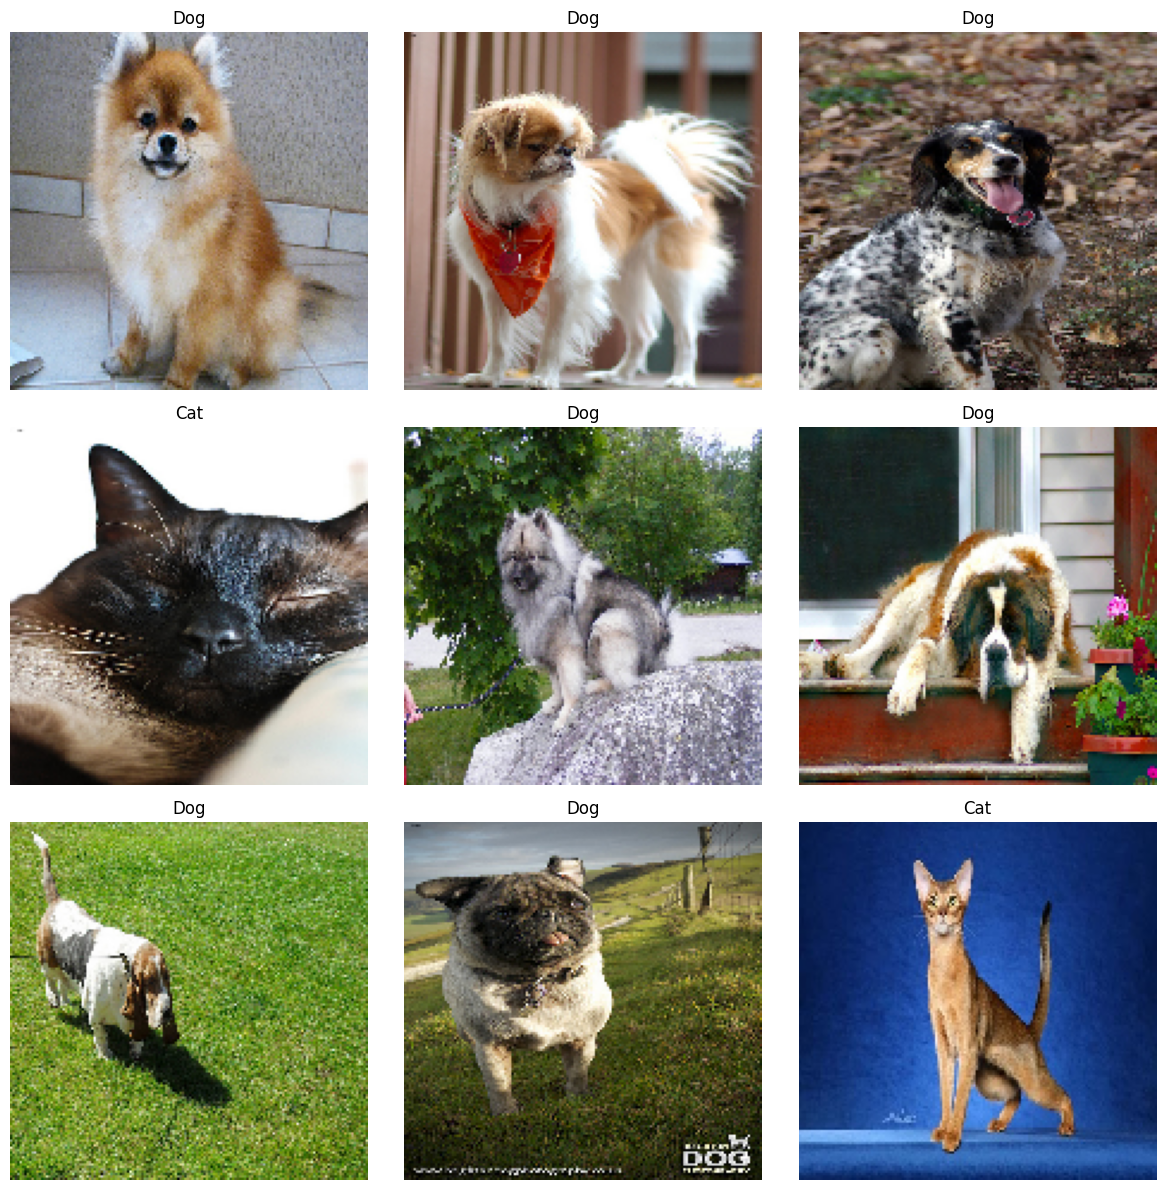

In [22]:
labels = {0: 'Cat', 1: 'Dog'}

# Visualisation de quelques images d'entrainement, redimensionnées
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]
        plt.title(labels.get(y_batch[0]))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break
plt.tight_layout()
plt.show()

### Première approche : réseau de convolution simple

Une première approche pour notre problème est d'utiliser un réseau convolutif. Nous allons construire une version simplifiée de AlexNet. 


Les trois premiers blocs de ce réseau sont de la forme :
- Une couche de convolution, avec des filtres de taille $3 \times 3$ filtres et qui utilise la fonction d'activation $\texttt{Relu}$. Le premier a 32 filtres, le deuxième 64 et le dernier 96
- Une couche de MaxPooling, avec une fenêtre de $2 \times 2$

A la suite de ces trois blocs, on trouve :
- Une couche flatten, afin que les canaux puissent être lus par le réseau de neuronne 
- Une couche dense avec 64 neuronnes, qui utilise la fonction d'activation $\texttt{Relu}$ 
- Une couche dropout, qui met à 0 50% des sorties de la couche précédente. Cela permet une certaine régularisation
- Une couche dense avec un neuronne et une couche d'activation $\texttt{Sigmoid}$ 

In [23]:
# Création du modèle 
 
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(img_width,img_height,3)))

cnn_simple.add(Conv2D(32, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(64, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(96, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Flatten())

cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(1, activation='sigmoid'))

I0000 00:00:1763569859.871424    4297 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13924 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9


In [24]:
# Entraînement du modèle
cnn_simple.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

epochs = 10

t_learning_cnn_simple = time.time()
cnn_simple_history = cnn_simple.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_cnn_simple = time.time() - t_learning_cnn_simple

print("Temps d'apprentissage pour %d epochs : %d secondes" % (epochs, t_learning_cnn_simple))

Epoch 1/10


/home/lelong/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-11-19 17:31:07.705541: I external/local_xla/xla/service/service.cc:163] XLA service 0x753124016b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-19 17:31:07.705568: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 2000 Ada Generation, Compute Capability 8.9
2025-11-19 17:31:08.081370: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-19 17:31:09.159505: I external/local_xla/xla/stream_e

  5/260 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4958 - loss: 0.7153 

I0000 00:00:1763569882.070421    6292 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.6785 - loss: 0.5927 - val_accuracy: 0.7021 - val_loss: 0.5627
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.7325 - loss: 0.5384 - val_accuracy: 0.7186 - val_loss: 0.5496
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.7498 - loss: 0.4992 - val_accuracy: 0.7607 - val_loss: 0.4900
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.7917 - loss: 0.4565 - val_accuracy: 0.7650 - val_loss: 0.4814
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.8062 - loss: 0.4211 - val_accuracy: 0.7857 - val_loss: 0.4611
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.8287 - loss: 0.3806 - val_accuracy: 0.7886 - val_loss: 0.4525
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8471 - loss: 0.3418 - val_accuracy: 0.7464 - val_loss: 0.5037
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8673 - loss: 0.3049 - val_accurac

In [25]:
# Fonctions utiles pour analyser les résultats

def prediction(model, train_generator, validation_generator):
    t_prediction = time.time()
    score_train = model.evaluate(train_generator, verbose=1)
    score_validation = model.evaluate(validation_generator, verbose=1)
    t_prediction = time.time() - t_prediction

    print('Train accuracy:', score_train[1])
    print('Validation accuracy:', score_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction)
    

def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, color='cadetblue', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, color='sandybrown', label='Validation accuracy')
    plt.title('Training et validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, color='cadetblue', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss, color='sandybrown', label='Validation loss')
    plt.title('Training et validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.9533 - loss: 0.1468
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7964 - loss: 0.5039
Train accuracy: 0.9532692432403564
Validation accuracy: 0.7964285612106323
Time Prediction: 16.06 seconds


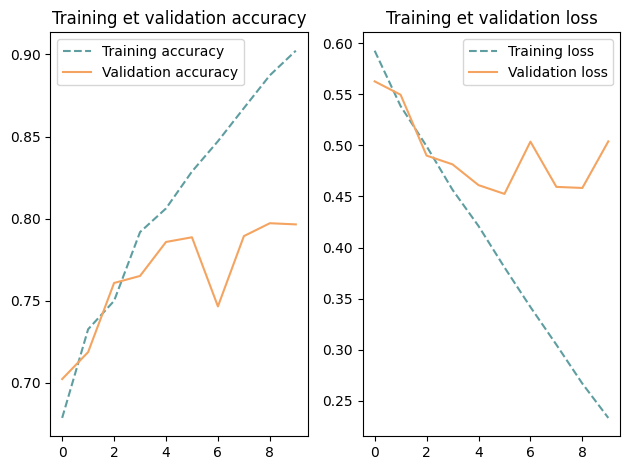

In [26]:
prediction(cnn_simple, train_generator, validation_generator)
plot_training_analysis(cnn_simple_history)

La précision obtenue est plutôt correcte : 82% pour les données de validation, et 95% pour les données d'entraînement. Cependant, on observe un surapprentissage clair : alors qu'à la moitié de l'apprentissage, les courbes de validation se stabilisent (cesse d'augmenter pour l'accuracy, de diminuer pour la loss), les courbes pour le training, elles, continuent d'évoluer. Une solution pour pallier ce problème est de faire de l'augmentation de data.

### CNN simple avec data augmentation

Afin d'éviter l'overfitting, une solution consiste à utilise l'augmentation de données. En effet, en transformant les images d'apprentissage (rotation, décalage...), on a un jeu de données bien plus grand, ce qui peut limiter le surapprentissage. On pourra ensuite suivre la même démarche que précédemment.

In [27]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size=(img_width,img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.


In [28]:
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(img_width,img_height,3)))

cnn_simple.add(Conv2D(32, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(64, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(96, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Flatten())

cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(1, activation='sigmoid'))

epochs = 10

cnn_simple.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_cnn_simple_augmented = time.time()

cnn_simple_augmented_history = cnn_simple.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)

t_learning_cnn_simple_augmented = time.time() - t_learning_cnn_simple_augmented

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn_simple_augmented))

Epoch 1/10


/home/lelong/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.6748 - loss: 0.6165 - val_accuracy: 0.6850 - val_loss: 0.5828
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.6775 - loss: 0.5956 - val_accuracy: 0.6850 - val_loss: 0.5605
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.6846 - loss: 0.5783 - val_accuracy: 0.6900 - val_loss: 0.5452
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.6971 - loss: 0.5701 - val_accuracy: 0.7071 - val_loss: 0.5526
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.7029 - loss: 0.5584 - val_accuracy: 0.7314 - val_loss: 0.5308
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.7142 - loss: 0.5517 - val_accuracy: 0.7521 - val_loss: 0.5129
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.7196 - loss: 0.5439 - val_accuracy: 0.7557 - val_loss: 0.5028
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.7265 - loss: 0.5404 - val_a

260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7500 - loss: 0.5268
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7386 - loss: 0.5430
Train accuracy: 0.75
Validation accuracy: 0.7385714054107666
Time Prediction: 13.43 seconds


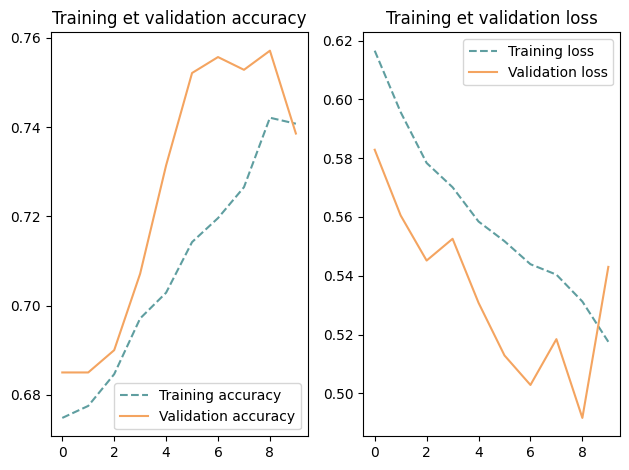

In [29]:
prediction(cnn_simple, train_generator, validation_generator)
plot_training_analysis(cnn_simple_augmented_history)

On remarque que l'overfitting a diminué. En effet, les courbes suivent désormais la même trajectoire. De plus, les précisions obtenues pour les données d'apprentissage et de validation sont du même ordre de grandeur. Même si ces résultats sont corrects (75 à 80% de précision), ils peuvent être améliorés. Une solution consiste à utiliser le Transfer Learning.

### Transfer Learning avec augmentation de données

Le Transfer Learning consiste à utiliser un réseau déjà entraîné pour notre problème. Cela permet de mieux détecter les formes de l'image, et ainsi de mieux distinguer les chats et les chiens. On utilise ici VGG16, qui est composé de 5 blocs de convolution puis d'un MLP classique.Nous allons garder les poids du réseau de convolution, et construire notre propre MLP ensuite.

In [30]:
conv_base = VGG16(
    weights = 'imagenet', # On garde les poids de l'entraînement sur le jeu de données ImageNet
    include_top = False,  # On ne garde pas la partie Dense
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Création du réseau en ajoutant un MLP après le réseau de convolution VGG16
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False # On fige les poids de VGG

vgg_combined.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
# Apprentissage 

epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

Epoch 1/5


2025-11-19 17:40:20.652030: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_604', 52 bytes spill stores, 52 bytes spill loads

2025-11-19 17:40:20.716429: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_604', 8 bytes spill stores, 8 bytes spill loads



260/260 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 0.7912 - loss: 0.4342 - val_accuracy: 0.8743 - val_loss: 0.2899
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.8460 - loss: 0.3397 - val_accuracy: 0.8921 - val_loss: 0.2558
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.8440 - loss: 0.3344 - val_accuracy: 0.8914 - val_loss: 0.2381
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.8581 - loss: 0.3116 - val_accuracy: 0.8914 - val_loss: 0.2485
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.8623 - loss: 0.3139 - val_accuracy: 0.9000 - val_loss: 0.2372
Learning time for 5 epochs : 134 seconds


260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9129 - loss: 0.2085
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9000 - loss: 0.2372
Train accuracy: 0.9128845930099487
Validation accuracy: 0.8999999761581421
Time Prediction: 15.75 seconds


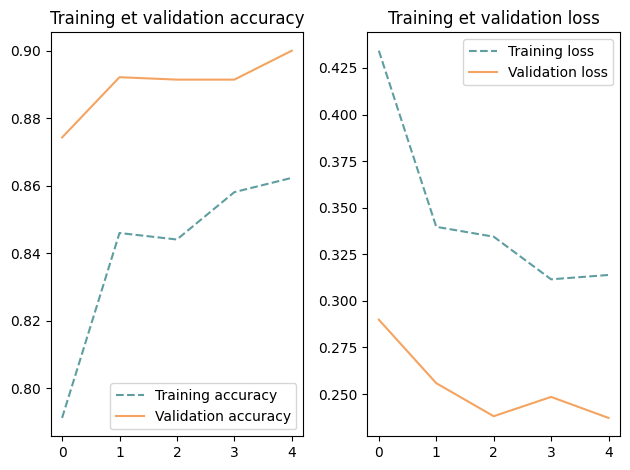

In [33]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_history)

Les précision obtenues sont bien meilleures que précédemment (environ 90%). On peut essayer de les améliorer en faisant un apprentissage sur les poids du réseau VGG.  

Nous allons libérer les poids du dernier bloc de convolution de VGG pour qu'il soit libre pour l'apprentissage. On espère ainsi que VGG s'adaptera à notre problème et qu'on aura des meilleurs résultats que précédemment. 

In [34]:
conv_base.trainable = True
for layer in conv_base.layers[:15]:
    layer.trainable = False # On fige les poids des 4 premiers blocs de convolution de VGG

In [35]:
# Apprentissage 
 
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-4), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned = time.time()
vgg_combined_tuned_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned = time.time() - t_learning_vgg_combined_tuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

Epoch 1/5


2025-11-19 17:43:12.218135: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_923', 4 bytes spill stores, 4 bytes spill loads



260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.8604 - loss: 0.3166 - val_accuracy: 0.9329 - val_loss: 0.1670
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.9046 - loss: 0.2232 - val_accuracy: 0.9357 - val_loss: 0.1711
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.9275 - loss: 0.1806 - val_accuracy: 0.9421 - val_loss: 0.1517
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.9404 - loss: 0.1488 - val_accuracy: 0.9529 - val_loss: 0.1196
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.9465 - loss: 0.1350 - val_accuracy: 0.9493 - val_loss: 0.1291
Learning time for 5 epochs : 130 seconds


260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9775 - loss: 0.0587
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9493 - loss: 0.1291
Train accuracy: 0.9775000214576721
Validation accuracy: 0.9492856860160828
Time Prediction: 15.55 seconds


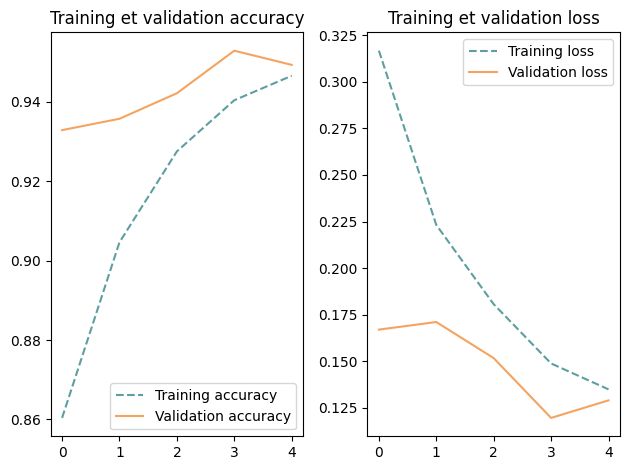

In [36]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_tuned_history)

Les résultats obtenus sont bien meilleurs que précédemment, jusqu'à atteindre 95% de précision. La fonction perte décroit elle aussi de manière significative par rapport à l'étape précédente. Essayons maintenant de faire un entraînement sur tous les poids du modèle. 

In [37]:
conv_base.trainable = True # On libère tous les poids du modèle

In [38]:
# Apprentissage 
 
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-5), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned2 = time.time()
vgg_combined_tuned_history2 = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned2 = time.time() - t_learning_vgg_combined_tuned2

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - accuracy: 0.9627 - loss: 0.0947 - val_accuracy: 0.9636 - val_loss: 0.1002
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.9690 - loss: 0.0777 - val_accuracy: 0.9550 - val_loss: 0.1129
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.9690 - loss: 0.0747 - val_accuracy: 0.9629 - val_loss: 0.1003
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.9756 - loss: 0.0668 - val_accuracy: 0.9621 - val_loss: 0.1024
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.9815 - loss: 0.0507 - val_accuracy: 0.9643 - val_loss: 0.1054
Learning time for 5 epochs : 130 seconds


260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9931 - loss: 0.0168
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9643 - loss: 0.1054
Train accuracy: 0.9930769205093384
Validation accuracy: 0.9642857313156128
Time Prediction: 15.89 seconds


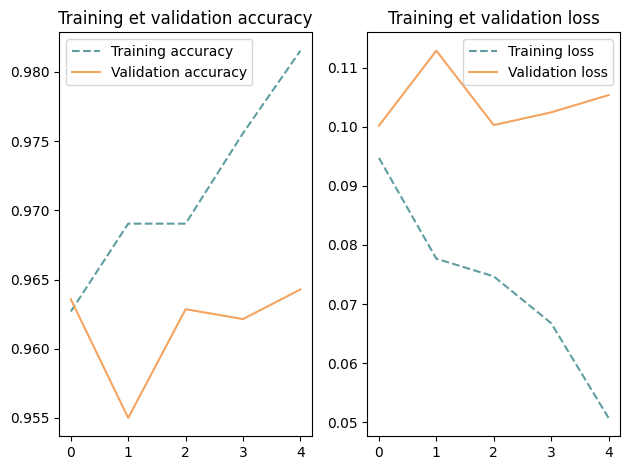

In [39]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_tuned_history2)

La précision obtenue avec ce dernier modèle monte jusqu'à 98%, ce qui est bien mieux. De même, la fonction perte a encore diminué de manière significative. Les fonctions de précision et de perte n'évoluant plus beaucoup, il est maintenant temps de tester ce modèle final.

### Test du modèle final

In [40]:
test_prediction = vgg_combined.predict(test_generator)
score_test = vgg_combined.evaluate(test_generator)
print('Test accuracy:', score_test[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9506 - loss: 0.1406
Test accuracy: 0.9506329298019409


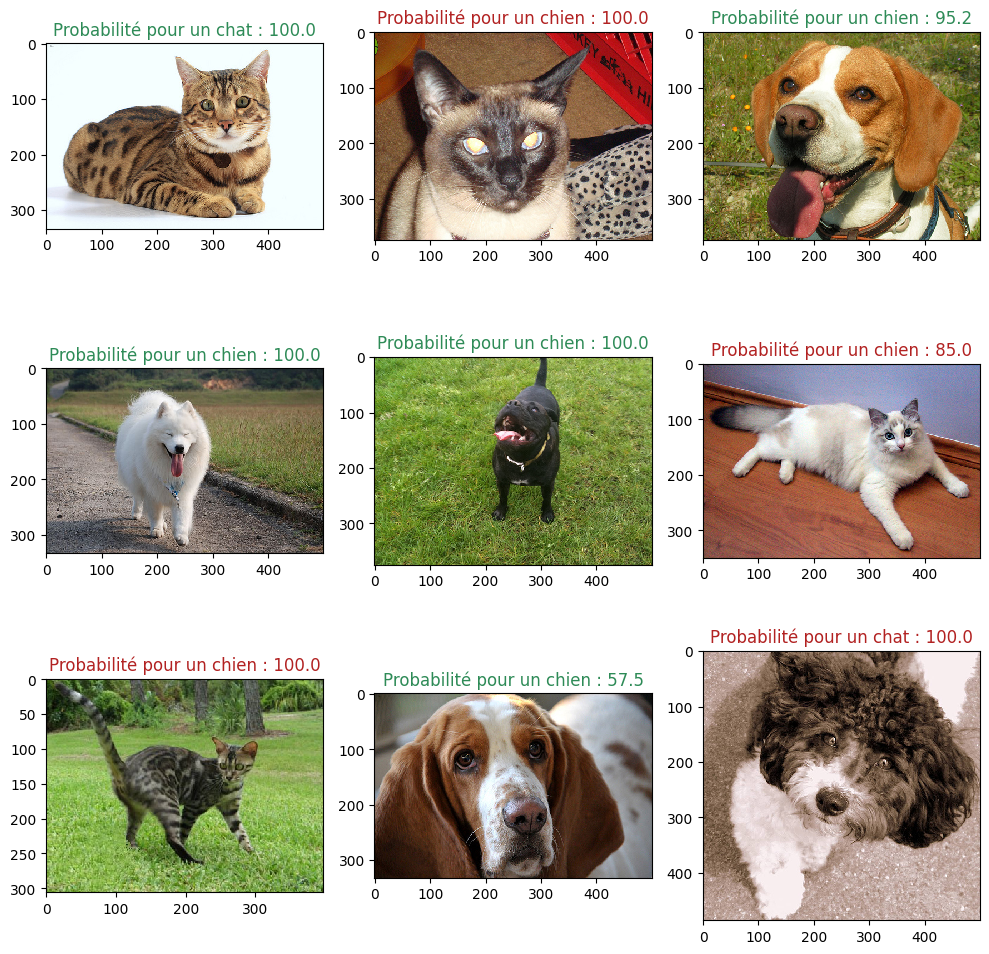

In [41]:
fig = plt.figure(figsize=(10,10))

test_imgs_idx = np.random.randint(low=0, high=test_df.shape[0], size=(9,))

for i, idx in enumerate(test_imgs_idx):
    filename = test_df['image'].iloc[idx]
    img = img_to_array(load_img(path_images + filename) ) / 255
    pred = test_prediction[idx][0]
    
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img, interpolation='nearest')
    color = "seagreen"
    type = test_df['animal'].iloc[idx]
    
    if pred >0.5:
        title = "Probabilité pour un chien : %.1f" % (pred*100)
        if type == 'cat':
            color = "firebrick"
    else:
        title = "Probabilité pour un chat : %.1f" %((1-pred)*100)
        if type == 'dog':
            color = "firebrick"
    ax.set_title(title, color=color)

plt.tight_layout()
plt.show()

En testant ce modèle sur le jeu de données de test, on obtient une précision de 96%, ce qui est tout à fait correct. En observant les images, on peut observer les erreurs du modèle.

## Classification fine

## Segmentation des animaux 

### Implémentation du réseau de type U-Net

Dans cette partie, nous allons nous intéresser à la segmentation des chiens et des chats grâce à un réseau U-Net: cela signifie que nous allons attribuer une "étiquette" à chaque pixel de notre image. On commence donc par préparer les images pour notre segmentation.

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │        448 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_6[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_12[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_13[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_14[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_15[0][0] 

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 123s 177ms/step - accuracy: 0.7610 - loss: 0.4853 - val_accuracy: 0.7835 - val_loss: 0.4512
Epoch 2/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.8025 - loss: 0.4230 - val_accuracy: 0.8130 - val_loss: 0.4072
Epoch 3/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.8253 - loss: 0.3843 - val_accuracy: 0.8392 - val_loss: 0.3637
Epoch 4/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.8442 - loss: 0.3491 - val_accuracy: 0.8570 - val_loss: 0.3310
Epoch 5/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.8579 - loss: 0.3216 - val_accuracy: 0.8699 - val_loss: 0.3041
Epoch 6/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.8681 - loss: 0.3011 - val_accuracy: 0.8739 - val_loss: 0.2936
Epoch 7/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.8757 - loss: 0.2857 - val_accuracy: 0.8671 - val_loss: 0.3058
Epoch 8/10
646/646 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.8813 - loss: 0.2740 

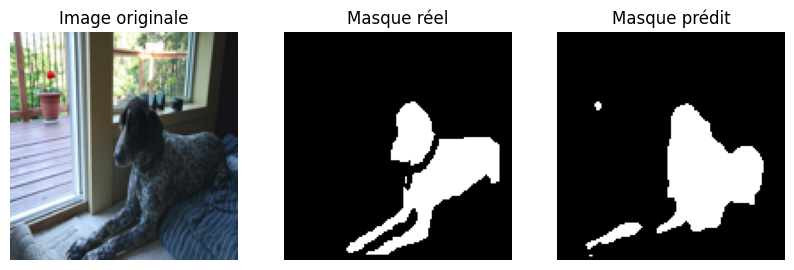

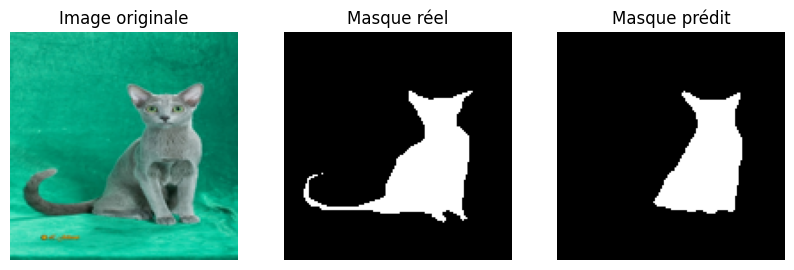

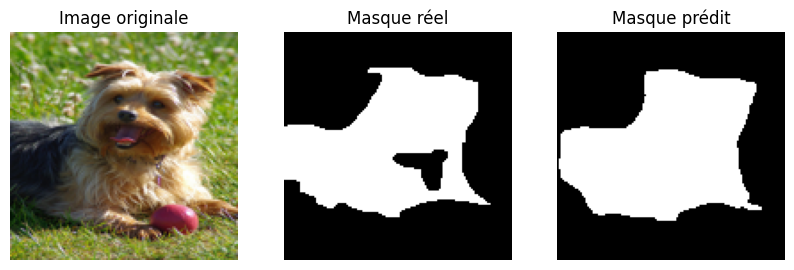

IoU: 0.54285717
Dice: 0.7037037


In [42]:
# SEGMENTATION D'ANIMAUX AVEC U-NET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# PARAMÈTRES GÉNÉRAUX

img_width = img_height = 128   # Test de taille uniforme mais pas convaincue par la taille, voir si amélioration possible
batch_size = 8

path_images = "./images/"
path_masks  = "./annotations/trimaps/"


# Split train / val / test
train_df = df.sample(frac=0.7, random_state=42)
temp_df  = df.drop(train_df.index)
validation_df = temp_df.sample(frac=0.5, random_state=42)
test_df = temp_df.drop(validation_df.index)

# GÉNÉRATEURS IMAGES + MASQUES

def image_generator(df, path_images, batch_size=8):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            imgs = []
            for fname in batch_df['image']:
                img = np.array(
                    Image.open(path_images + fname)
                    .resize((img_width,img_height))
                    .convert("RGB")          # ⚠️ garantit 3 canaux
                )
                img = img / 255.0
                imgs.append(img)
            yield np.array(imgs, dtype=np.float32)


def mask_generator(df, path_masks, batch_size=8):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            masks = []
            for fname in batch_df['image']:
                mask = np.array(
                    Image.open(path_masks + fname.replace('.jpg','.png'))
                    .resize((img_width,img_height))
                    .convert("L")            # ⚠️ niveaux de gris = 1 canal
                )
                # Binarisation : 1 = animal, 0 = fond
                mask_binary = np.where(mask == 1, 1, 0)[..., np.newaxis]
                masks.append(mask_binary)
            yield np.array(masks, dtype=np.float32)


# Fusionner les deux générateurs pour créer (image, masque)
def combined_generator(df, path_images, path_masks, batch_size=8):
    img_gen = image_generator(df, path_images, batch_size)
    mask_gen = mask_generator(df, path_masks, batch_size)
    while True:
        imgs = next(img_gen)
        masks = next(mask_gen)
        yield imgs, masks


# Train et Validation generators
train_generator = combined_generator(train_df, path_images, path_masks, batch_size)
validation_generator = combined_generator(validation_df, path_images, path_masks, batch_size)

# MODÈLE U-NET

def unet(input_size=(img_width, img_height, 3)):
    inputs = Input(input_size)

    # --- Encodeur ---
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # --- Bottleneck ---
    c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    # --- Decodeur ---
    u5 = UpSampling2D()(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D()(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D()(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model


model = unet()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ENTRAÎNEMENT

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(validation_df) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

# MÉTRIQUES DE SEGMENTATION

def iou(y_true, y_pred, smooth=1e-6):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


# VISUALISATION DE RÉSULTATS

imgs, masks = next(train_generator)
preds = model.predict(imgs[:3])

for i in range(3):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(imgs[i])
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(masks[i,:,:,0], cmap="gray")
    plt.title("Masque réel")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(preds[i,:,:,0] > 0.5, cmap="gray")
    plt.title("Masque prédit")
    plt.axis("off")

    plt.show()

print("IoU:", iou(masks[:1], preds[:1]).numpy())
print("Dice:", dice_coef(masks[:1], preds[:1]).numpy())


## Analyse Comparative

Dans cette partie, on s'interesse au comportement du modèle U-net en fonction de la race. On cherche donc notemment à répondre aux questions suivantes : 
- Est-ce que certaines races sont mieux segmentées que d'autres ? 
- Est ce qu'il est plus facile de segmenter un chien ou un chat ? 

In [44]:
# Tableau récapitulatif des performanes par images

liste_results = []

for i in range(len(test_df)):
    filename    = test_df['image'].iloc[i]
    race        = test_df['class'].iloc[i]     # nom de la race
    animal_type = test_df['type'].iloc[i]      # "Cat" ou "Dog"

    # Image
    img = np.array(
        Image.open(os.path.join(path_images, filename))
        .resize((img_width, img_height))
        .convert("RGB")
    ) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W, 3)

    # Masque
    mask = np.array(
        Image.open(os.path.join(path_masks, filename.replace('.jpg', '.png')))
        .resize((img_width, img_height), resample=Image.NEAREST)
        .convert("L")
    )

    # 1 = animal, 2 = fond, 3 = non classifié  --> binaire : animal = 1, le reste = 0
    mask_binary = np.where(mask == 1, 1.0, 0.0)[..., np.newaxis].astype(np.float32)
    mask_binary = np.expand_dims(mask_binary, axis=0)  # (1, H, W, 1)


    # Prédiction
    pred = model.predict(img, verbose = 0)  # (1, H, W, 1) # verbose pour enlever les barres de progression

    # Score IOU et Dice 
    iou_score  = float(iou(mask_binary, pred).numpy())
    dice_score = float(dice_coef(mask_binary, pred).numpy())

    # Stockage des performances
    liste_results.append({
        "image": filename,
        "race": race,             
        "type": animal_type,
        "iou": iou_score,
        "dice": dice_score
    })
results_df = pd.DataFrame(liste_results)
results_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

image        race  type       iou      dice
0  Abyssinian_101.jpg  Abyssinian     1  0.293462  0.453762
1  Abyssinian_102.jpg  Abyssinian     1  0.550080  0.709744
2  Abyssinian_104.jpg  Abyssinian     1  0.817933  0.899849
3  Abyssinian_105.jpg  Abyssinian     1  0.653028  0.790099
4  Abyssinian_109.jpg  Abyssinian     1  0.661911  0.796566

             race  mean_iou  median_iou   std_iou  mean_dice  count
23     leonberger  0.765644    0.790911  0.133561   0.860328     30
20       havanese  0.760527    0.795531  0.136183   0.856703     28
2          Birman  0.756505    0.762584  0.115573   0.856235     34
25   newfoundland  0.755501    0.797855  0.152904   0.849383     31
22       keeshond  0.752340    0.786769  0.141664   0.850087     39
7         Persian  0.750416    0.815749  0.189636   0.839019     33
4         British  0.741261    0.757131  0.164707   0.840153     30
26     pomeranian  0.737949    0.755605  0.121771   0.843472     27
30       scottish  0.732669    0.746717  0.124218   0.839337     31
6           Maine  0.720670    0.785151  0.201674   0.815397     21
29        samoyed  0.720403    0.788383  0.200272   0.818474     26
8         Ragdoll  0.714913    0.743543  0.154603   0.823852     32
13         basset  0.713063    0.760307  0.170290   0.818527     29
3          Bombay  0.699889    0.730007  0.16570

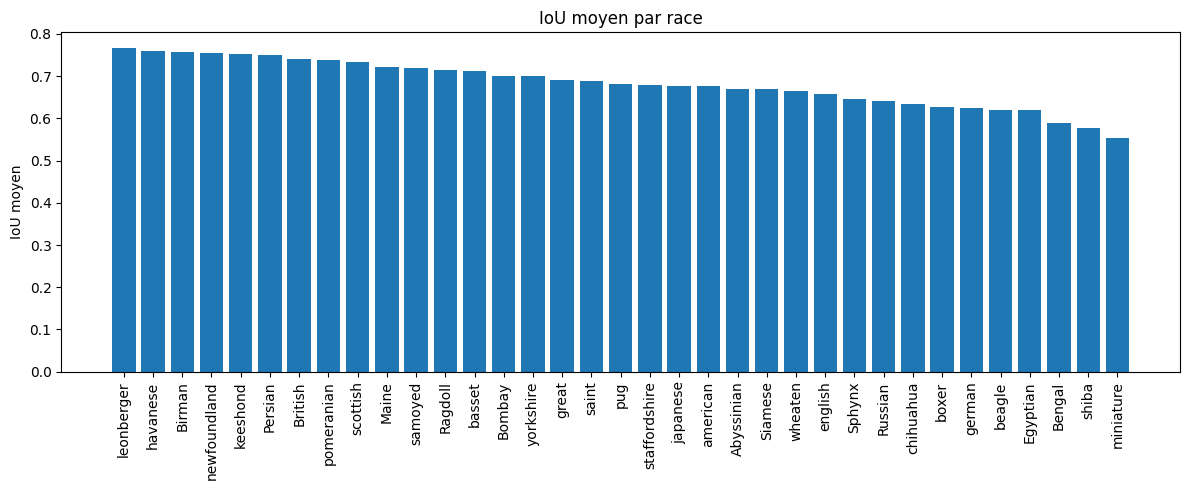

In [46]:
# Analyse comparative par race
# Est ce que certaines races sont plus difficiles à segmenter que d'autres ?
# 1) Statistiques par race
stats_race = results_df.groupby("race").agg(
    mean_iou   = ("iou", "mean"),
    median_iou = ("iou", "median"),
    std_iou    = ("iou", "std"),
    mean_dice  = ("dice", "mean"),
    count      = ("iou", "count")
).reset_index()

# 2) Trier pour voir les meilleures/pire races
# Comme ls effectif sont proches les moyennes sont peu influencées
stats_race_trie = stats_race.sort_values(by="mean_iou", ascending=False)

print(stats_race_trie)

# 3) Visualisation : barplot des IoU moyens par race
plt.figure(figsize=(12, 5))
plt.bar(stats_race_trie["race"], stats_race_trie["mean_iou"])
plt.xticks(rotation=90)
plt.ylabel("IoU moyen")
plt.title("IoU moyen par race")
plt.tight_layout()
plt.show()

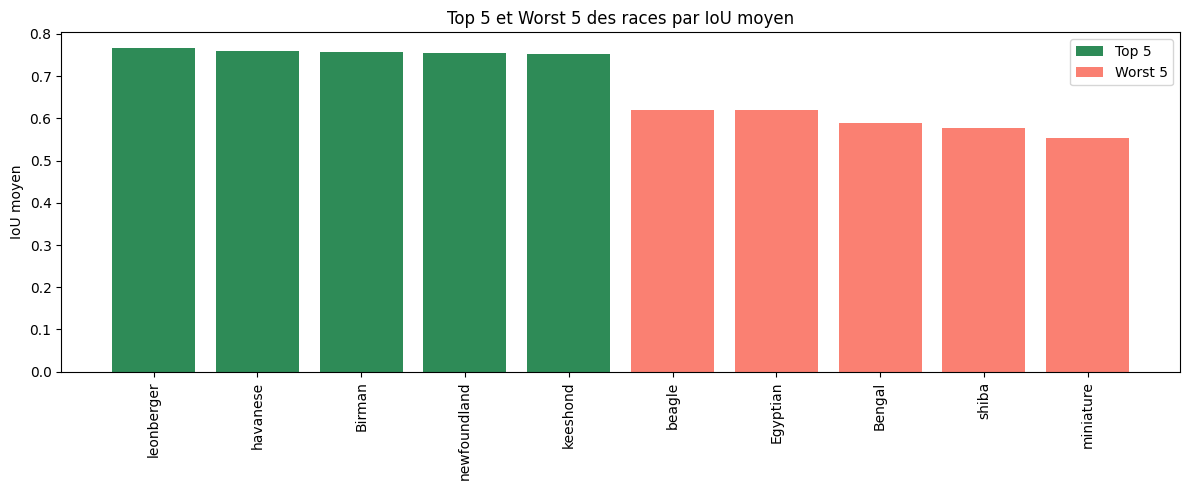

In [47]:
# Focus sur les 5 meilleures et les 5 pires races
top10  = stats_race_trie.head(5)
worst10 = stats_race_trie.tail(5)
plt.figure(figsize=(12, 5))
plt.bar(top10["race"], top10["mean_iou"], color='seagreen', label='Top 5')
plt.bar(worst10["race"], worst10["mean_iou"], color='salmon', label='Worst 5')
plt.xticks(rotation=90)
plt.ylabel("IoU moyen")
plt.title("Top 5 et Worst 5 des races par IoU moyen")
plt.legend()
plt.tight_layout()
plt.show()

   type  mean_iou  median_iou   std_iou  mean_dice  count
0     1  0.683760    0.718984  0.179874   0.796074    382
1     2  0.681724    0.714719  0.168751   0.797012    727


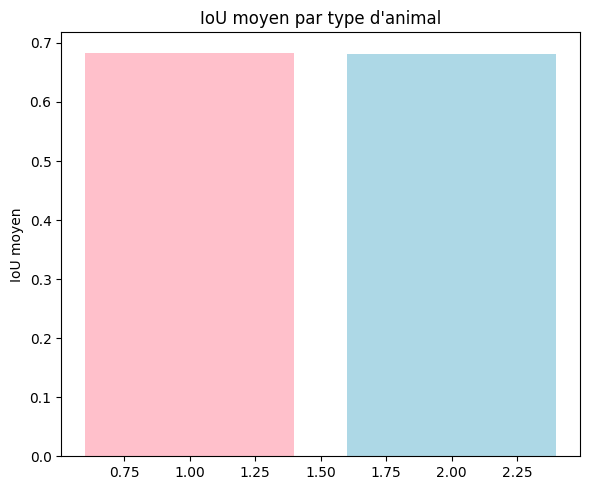

/tmp/ipykernel_4297/1667497832.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="type", y="iou", data=results_df, palette=['pink', 'lightblue'])


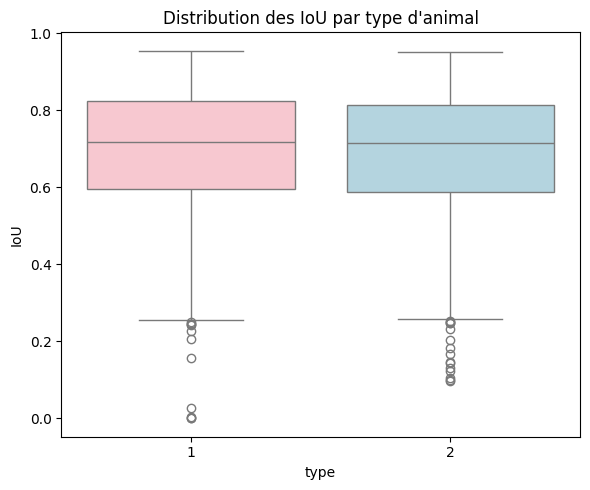

In [49]:
#Analyse comparative par type d'animal : Chat vs Chien
#Est ce qu'il est plus facile de segmenter les chats ou les chiens ?
# Statistiques par type d'animal
stats_type = results_df.groupby("type").agg(
    mean_iou   = ("iou", "mean"),
    median_iou = ("iou", "median"),
    std_iou    = ("iou", "std"),
    mean_dice  = ("dice", "mean"),
    count      = ("iou", "count")
).reset_index()

print(stats_type)   

# Visualisation : barplot des IoU moyens par type d'animal
plt.figure(figsize=(6, 5))
plt.bar(stats_type["type"], stats_type["mean_iou"], color=['pink', 'lightblue'])
#plt.bar(stats_type["type"], stats_type["mean_iou"], color=["#ffb6c1", "#add8e6"])
plt.ylabel("IoU moyen")
plt.title("IoU moyen par type d'animal")
plt.tight_layout()
plt.show()  

# Visualisation : boxplot des IoU par type d'animal
plt.figure(figsize=(6, 5))
sns.boxplot(x="type", y="iou", data=results_df, palette=['pink', 'lightblue'])
plt.ylabel("IoU")
plt.title("Distribution des IoU par type d'animal")
plt.tight_layout()
plt.show() 

On cherche à comparer les moyennes de deux distributions :
ici : IoU des chats vs IoU des chiens
hypothèse nulle H0 : les deux groupes ont la même moyenne
hypothèse alternative H1 : les moyennes sont différentes

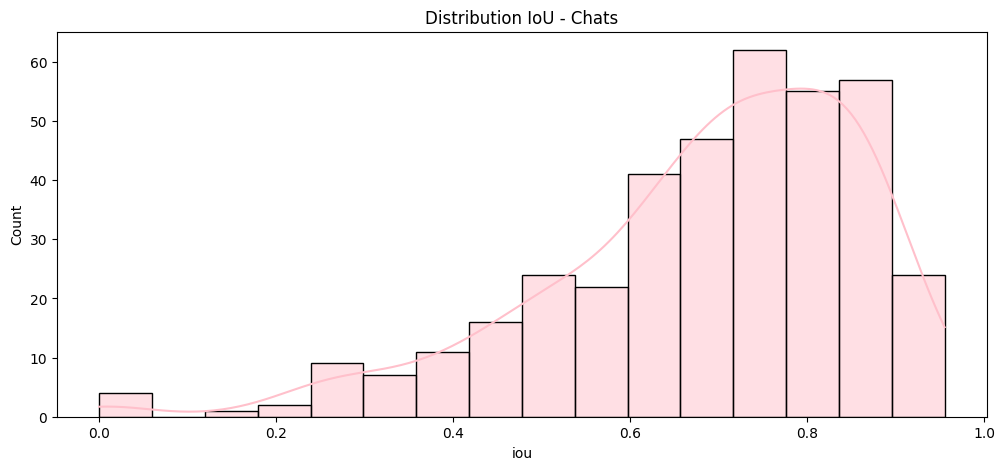

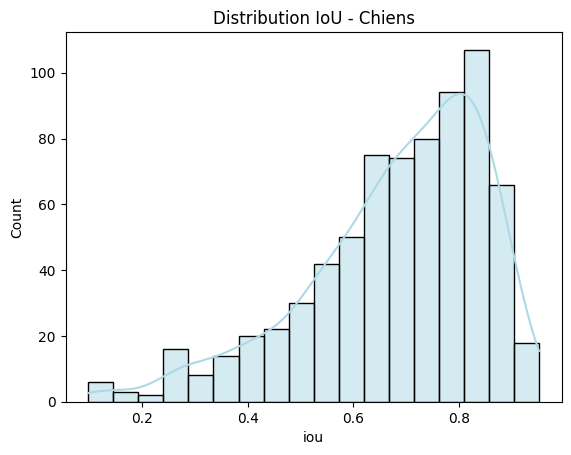

In [54]:
# Histogrammes des IoU pour les chats et les chiens

#Pour vérifier si c'est gaussien ou pas
iou_chats = results_df[results_df["type"] == 1]["iou"]
iou_chiens = results_df[results_df["type"] == 2]["iou"]


plt.figure(figsize=(12, 5))
sns.histplot(iou_chats, kde=True, color="pink")
plt.title("Distribution IoU - Chats")
plt.show()

sns.histplot(iou_chiens, kde=True, color="lightblue")
plt.title("Distribution IoU - Chiens")
plt.show()


Dans la segmentation :
les IoU sont souvent pas du tout gaussiens
distribution souvent asymétrique (beaucoup de bons IoU + quelques mauvais)

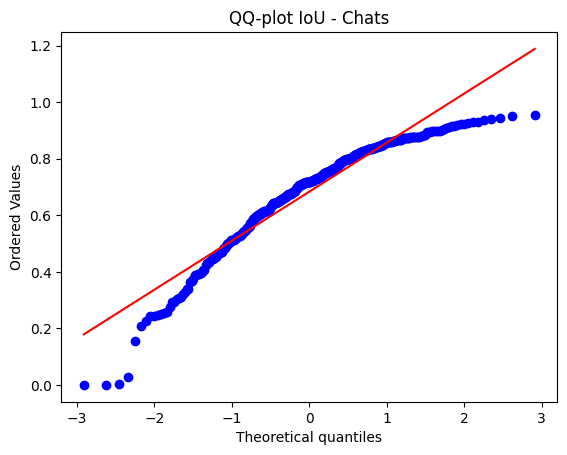

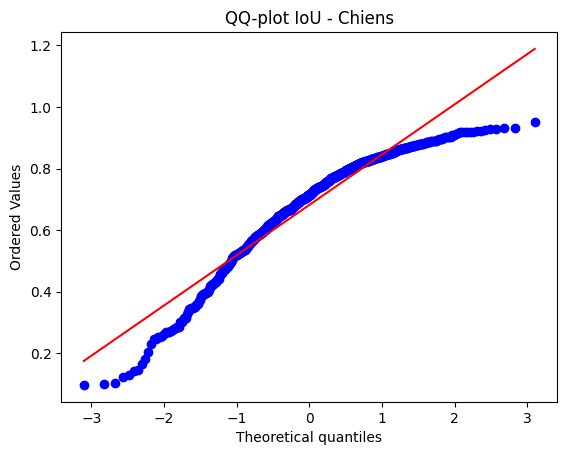

In [55]:
#QQ-plot des IoU pour les chats et les chiens

stats.probplot(iou_chats, dist="norm", plot=plt)
plt.title("QQ-plot IoU - Chats")
plt.show()

stats.probplot(iou_chiens, dist="norm", plot=plt)
plt.title("QQ-plot IoU - Chiens")
plt.show()

In [57]:
#Test de normalité de Shapiro-Wilk
#Attention : avec beaucoup de données, Shapiro rejette souvent à tort.

stat, p = shapiro(iou_chats)
print("Shapiro Chats:", p)

stat, p = shapiro(iou_chiens)
print("Shapiro Chiens:", p)


Shapiro Chats: 2.656070823014762e-13
Shapiro Chiens: 3.607357159182082e-18


Des p très petit donc on rejette l'hypothèse de normalité. 

In [58]:
#Si gaussien on peut faire un t-test, sinon un test de mann-whitney
from scipy.stats import ttest_ind, mannwhitneyu

# Mann-Whitney U test
stat, p_value = mannwhitneyu(iou_chats, iou_chiens)
print("Mann-Whitney U test entre IoU des chats et des chiens : stat=%.3f, p=%.3f" % (stat, p_value))
if p_value < 0.05:
    print("Différence significative entre les IoU des chats et des chiens (p < 0.05)")
else:
    print("Pas de différence significative entre les IoU des chats et des chiens (p >= 0.05)")


Mann-Whitney U test entre IoU des chats et des chiens : stat=141709.000, p=0.574
Pas de différence significative entre les IoU des chats et des chiens (p >= 0.05)


In [ ]:
'''# T-test
stat, p_value = ttest_ind(iou_chats, iou_chiens)
print("T-test entre IoU des chats et des chiens : stat=%.3f, p=%.3f" % (stat, p_value))
if p_value < 0.05:
    print("Différence significative entre les IoU des chats et des chiens (p < 0.05)")
else:
    print("Pas de différence significative entre les IoU des chats et des chiens (p >= 0.05)")#!/usr/bin/env python3'''
